# Snuffelfiets kwartaalrapportages

## Settings.

In [15]:
# Generieke imports, variabelen en functies.

from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd

from snuffelfiets import inlezen, opschonen, analyse, plotting

In [16]:
api_key = ''  # voeg hier de API key toe

data_directory = Path('~','snuffelfiets').expanduser()
# data_directory = Path('~','kwartaalrapportage').expanduser()
prefix = 'api_gegevens'

# date range selection settings
quarter = 'Q1'
year = 2024
quarters = {
    'Q1': [1, 2, 3], 
    'Q2': [4, 5, 6], 
    'Q3': [7, 8, 9], 
    'Q4': [10, 11, 12], 
}
yq = f'{year}_{quarter}'


In [17]:
# data processing settings
error_code_selection = []
rit_splitter_interval = 1800  # s
ritfilters = dict(
    min_measurements=2,     # #
    max_duration=360,       # minutes
    max_distance=200,       # kilometers
    min_average_speed=1,    # km/h
    max_average_speed=35,   # km/h
    )
threshold_pm2_5 = 100

# mapbox settings (in degrees latlon)
b = {
    'N': [52.303634, 5.013507],
    'Z':  [51.858631, 5.040462],
    'O':  [51.954780, 5.627990],
    'W':  [52.226808, 4.794457],
}
mapbox_center = {
    'lat': b['Z'][0] + 0.5 * (b['N'][0] - b['Z'][0]),
    'lon': b['W'][1] + 0.5 * (b['O'][1] - b['W'][1]),
}
mapbox_extent = 1
hexagon_size = 0.010
hexbin_args = {
    'agg_func': np.nanmean,
    'color_continuous_scale': plotting.discrete_colorscale(),
    'range_color': [0, threshold_pm2_5],
    'min_count': 2,
    'animation_frame': None,
    'width': 1920,
    'height': 1080,
    'opacity': 1.0,
    'zoom': 10,
    'center': mapbox_center,
    }
# add Utrecht polygons

# Import Utrecht province and township polygons
filepaths = plotting.download_borders_utrecht(data_directory)
provincies, gemeenten = plotting.get_borders_utrecht(data_directory, *filepaths)
mapbox_layers = [{
    "name": "Gemeenten",
    "below": 'traces',
    "sourcetype": "geojson",
    "type": "line",
    "color": "gray",
    "source": gemeenten,
    }, 
    {
    "name": "Provincies",
    "below": 'traces',
    "sourcetype": "geojson",
    "type": "line",
    "color": "red",
    "source": provincies,
    }]
layout_args = {
    'mapbox_style': 'open-street-map',
    'coloraxis_showscale': False,
    'mapbox_layers': mapbox_layers,
    }

# Directories
output_directory = Path(data_directory, yq)
output_directory.mkdir(parents=True, exist_ok=True)

print(f'Analysing quarter {yq}; writing output to {output_directory}.')


Analysing quarter 2024_Q1; writing output to /Users/amferraboli/snuffelfiets/2024_Q1.


## Read data with API and save as monthly CSV.

This data is uploaded to the Google Drive of the MCU dataclub:
Dataclub MCU > Project Snuffelfiets > data > api_gegevens_{????}-{??}.csv

In [4]:
years = [2024]  # [2021, 2022, 2023]
months = range(2, 3)  # range(1, 13)

for y in years:
    for m in months:
        inlezen.monthly_csv_dump(api_key, y, m, data_directory, prefix)


url= https://ckan-dataplatform-nl.dataplatform.nl/api/3/action/datastore_search_sql
sql-statement= SELECT * from "provincie_utrecht_snuffelfiets_measurement_rydruofi" WHERE "recording_timestamp" > '2024-02-01' AND "recording_timestamp" < '2024-03-01'


SystemExit: api-call mislukt: foutcode= 403; {"help": "https://ckan.dataplatform.nl/api/3/action/help_show?name=datastore_search_sql", "success": false, "error": {"message": "Toestemming geweigerd: Gebruiker  is niet gemachtigd om bron provincie_utrecht_snuffelfiets_measurement_rydruofi te lezen ", "__type": "Authorization Error"}}


/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Read data from monthly CSV's.


In [18]:
# Read data from saved csvs.
dfs = []
for m in quarters[quarter]:
    filename = f'{prefix}_{year}-{m:02d}.csv' #reading m with minimum of 2 integer digits, completing with zeroes
    # p = Path(data_directory, filename)
    df = pd.read_csv(filename)
    dfs.append(df)
df = pd.concat(dfs)

print(f'Read {df.shape[0]} measurements.')


Read 676664 measurements.


## Data preparation

In [19]:
# Get some insight in the error modes present in the dataset.
opschonen.analyse_errors(df)


code          0: count          617086
code         32: count           32187
             32:                        type       : Allowed Error, device maybe indoors
             32:                        description: GPS ERROR 2: No GPS Fix
code        512: count             792
            512:                        type       : Critical Error
            512:                        description: PM ERROR 1: Sensor Not Found
code        533: count            2146
              1:                        type       : Critical Error
              1:                        description: ACCELEROMETER ERROR 1: Sensor Not Found
              4:                        type       : Critical Error
              4:                        description: BME ERROR 1: Sensor Not Found
             16:                        type       : Critical Error
             16:                        description: GPS ERROR 1: Sensor Not Found
            512:                        type       : Critical Err

In [7]:
# Drop the errors.
df = opschonen.verwijder_errors(df, error_codes=error_code_selection)


Removing             792 measurements with error_code             512
Removing           32187 measurements with error_code              32
Removing              33 measurements with error_code             544
Removing           22180 measurements with error_code            2048
Removing            1599 measurements with error_code            2080
Removing             132 measurements with error_code            2560
Removing              66 measurements with error_code            2592
Removing             421 measurements with error_code             552
Removing            2146 measurements with error_code             533
Removing              22 measurements with error_code             573

Error codes remaining: [0]
Measurements remaining: 617086.


In [20]:
# Convert timestamps to datetime objects and add dt columns.
df = analyse.bewerk_timestamp(df, split=True)


Added ['date_time', 'day', 'week', 'month', 'quarter', 'year'] columns to dataframe.


In [21]:
# Split measurements into rides and add cycle stat columns.
df = analyse.split_in_ritten(df, t_seconden=rit_splitter_interval)


/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:198: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_id['duur'][rit_mask] = np.timedelta64(0, 's')
/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:211: FutureWarning: ChainedAs

Added ['duur', 'afstand', 'snelheid', 'rit_id'] columns to dataframe.


/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:198: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_id['duur'][rit_mask] = np.timedelta64(0, 's')
/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:211: FutureWarning: ChainedAs

In [22]:
# Filter the rides.
df = analyse.filter_ritten(df, **ritfilters)


       159 rides were removed because number of measurements was < 2
        56 rides were removed because duration was >= 360 minutes
      2316 rides were removed because distance was >= 200 kilometers
         3 rides were removed because average speed was >= 35 km/h
      1735 rides were removed because average speed was < 1 km/h


## Summary Snuffelfiets statistics.

In [23]:
def printfun(period, sumstats):

    print(f'\n==== {period} ====\n')

    print(f"Aantal fietsers: {sumstats['fietsers']['N']}\n")

    print(f"{' ':20} {'totaal':12} {'gemiddeld':12} {'topper':12}")
    print(f'-' * 56)
    stat = 'uren'
    print(f"FIETSTIJD [uur]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'afstand'
    print(f"AFSTAND    [km]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'ritten'
    print(f"RITTEN      [#]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")


In [24]:
# Print the summary statistics for the quarter.
sumstats = analyse.summary_stats(df)
printfun(quarter, sumstats)



==== Q1 ====

Aantal fietsers: 62

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    970.158333    15.647715    59.000000
AFSTAND    [km]:  10235.972388   165.096329   656.562757
RITTEN      [#]:   1922.000000    31.000000   118.000000


In [25]:
# Print the summary statistics for the months in the quarter.
for m, dfm in df.groupby('month'):
    sumstats = analyse.summary_stats(dfm)
    printfun(f'{year}{m:02d}', sumstats)



==== 202401 ====

Aantal fietsers: 49

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    296.099167     6.042840    21.000000
AFSTAND    [km]:   3006.723717    61.361709   184.628870
RITTEN      [#]:    632.000000    12.897959    35.000000

==== 202402 ====

Aantal fietsers: 46

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    321.426944     6.987542    18.000000
AFSTAND    [km]:   3532.296057    76.789045   267.611764
RITTEN      [#]:    599.000000    13.021739    43.000000

==== 202403 ====

Aantal fietsers: 46

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    352.632222     7.665918    24.000000
AFSTAND    [km]:   3696.952614    80.368535   236.726134
RITTEN      [#]:    691.000000    15.021739    40.000000


## Air quality evaluation

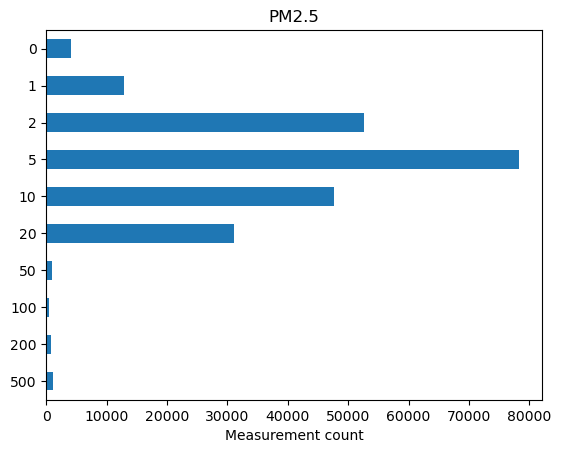

In [26]:
# Plot categorical hist of PM2.5 values.
def plot_hbar_cat(df, bins, labels, title=''):
    df[f'{var}_cat'] = pd.cut(df[var], bins=bins, labels=labels)
    ax = df[['entity_id', f'{var}_cat']].groupby(f'{var}_cat', observed=False).count().plot.barh(stacked=True, legend=False)
    ax.invert_yaxis()
    ax.axes.get_yaxis().get_label().set_visible(False)
    ax.axes.get_xaxis().set_label_text("Measurement count")
    ax.set_title(title)

var = 'pm2_5'
bins = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
labels = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]
plot_hbar_cat(df, bins, labels, title='PM2.5')


/var/folders/c9/ffw0stlx71d8wxzkj6rb4v1c0000gn/T/ipykernel_84990/2544659271.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pm2_5'][df['pm2_5'] >= threshold_pm2_5] = np.nan


<Axes: >

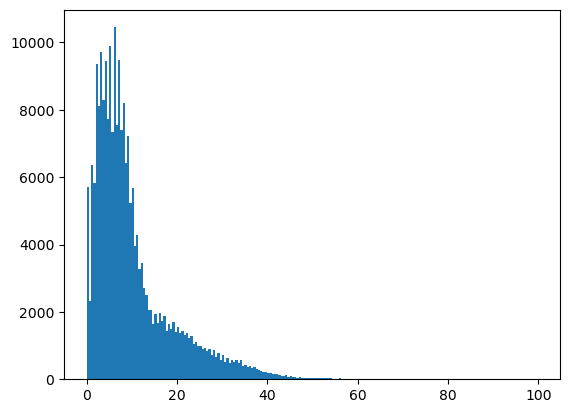

In [27]:
# Limit the PM2.5 values. FIXME: we need a better and validated method
df['pm2_5'][df['pm2_5'] >= threshold_pm2_5] = np.nan

# Plot the histogram.
df['pm2_5'].hist(bins=200, grid=False)


In [28]:
## Hexbin plots of PM2.5

# Remove datapoints outside of the map area 
#   because it would take a very long time to process large areas.
#   TODO: doe dit op ritniveau (verwijderen ritten deels of geheel buiten de target area)
latlon = {
    'latitude': {'center': mapbox_center['lat'], 'extent': mapbox_extent},
    'longitude': {'center': mapbox_center['lon'], 'extent': mapbox_extent},
}
df = opschonen.filter_lat_lon(df, latlon)

# Plot the data for each month.
for m, dfm in df.groupby('month'):

    yyyymm = f'{year}{m:02d}'
    hexbin_args['title'] = yyyymm
    fig = plotting.hexbin_mapbox(dfm, hexagon_size, hexbin_args, layout_args)

    # Save image
    filestem = f'{yyyymm}_hexbin'
    output_stem = Path(output_directory, filestem)
    fig.write_html(f"{output_stem}.html")
    fig.write_image(f"{output_stem}.png")
    fig.write_image(f"{output_stem}.pdf")


/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:175: RuntimeWarning: Mean of empty slice
  lattice1[i, j] = agg_func(vals)
/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:182: RuntimeWarning: Mean of empty slice
  lattice2[i, j] = agg_func(vals)
/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:182: RuntimeWarning:

Mean of empty slice

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/plotly/figure_factory/_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/plotly/figu

### Temperature and PM 2.5 concentrations

In [12]:
df.columns

Index(['entity_id', 'vertical_accuracy', 'voc', 'voltage', 'acc_max', 'no2',
       'temperature', 'version_major', 'latitude', 'pm2_5',
       'horizontal_accuracy', 'receive_timestamp', 'pressure', 'pm1_0',
       'version_minor', 'pm10', 'longitude', 'humidity', 'recording_timestamp',
       '_id', 'error_code', 'date_time', 'day', 'week', 'month', 'quarter',
       'year', 'duur', 'rit_id', 'afstand', 'snelheid', 'pm2_5_cat'],
      dtype='object')

In [120]:
# Specify the date range.
import calendar
months = quarters[quarter]
lastday = calendar.monthrange(year, quarters[quarter][2])[1]
dt_min = f'{year}-{months[0]}-1 00:00:00'
dt_max = f'{year}-{months[2]}-{lastday} 23:59:59'

# Import the weather data - rain
dfr = analyse.import_knmi_data(dt_min, dt_max, interval='dag', stations=[260], variables=['RH', 'FG', 'TG', 'PG', 'UG'])
dfr.RH = dfr.RH.values / 10  # RH: Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm), divindg by 10 becomes 1 mm
dfr.TG = dfr.TG.values / 10  # Etmaalgemiddelde temperatuur (in 0.1 graden Celsius), dividing by 10 becomes 1 graden Celsius
dfr.FG = dfr.FG.values / 10 # Etmaalgemiddelde windsnelheid (in 0.1 m/s), by 10 becomes 1m/s
dfr.PG = dfr.PG.values / 10 # Etmaalgemiddelde luchtdruk herleid tot zeeniveau (in 0.1 hPa) berekend uit 24 uurwaarden, by 10 becomes 1hPa

In [45]:
# Print the monthly pm2.5 average.
df.loc[: , ['month', 'pm2_5']].groupby('month').mean()


,pm2_5
month,
1,10.733758
2,8.337622
3,11.704905


In [57]:
dfr.head()

,STN,RH,FG,TG,PG,UG
YYYYMMDD,,,,,,
2024-01-01 00:00:00+01:00,260,10.3,5.5,7.4,1001.3,87
2024-01-02 00:00:00+01:00,260,24.0,6.6,10.5,987.6,91
2024-01-03 00:00:00+01:00,260,12.4,5.6,9.4,989.2,88
2024-01-04 00:00:00+01:00,260,10.6,2.5,7.6,1001.0,94
2024-01-05 00:00:00+01:00,260,5.5,3.9,7.0,997.0,93


In [90]:
# Print the monthly rainfall sum.
dfr['month'] = dfr.index.month
dfr.loc[: , ['month', 'RH']].groupby('month').sum()


,RH
month,
1,94.5
2,122.3
3,57.7


In [91]:
# Print the monthly temp average.
dfr.loc[: , ['month', 'TG']].groupby('month').mean()

,TG
month,
1,3.890323
2,8.182759
3,8.951613


In [93]:
# Print the monthly wind speed average.
dfr.loc[: , ['month', 'FG']].groupby('month').mean()

,FG
month,
1,4.122581
2,4.172414
3,3.506452


In [94]:
# Print the monthly humidity average.
dfr.loc[: , ['month', 'UG']].groupby('month').mean()

,UG
month,
1,83.483871
2,88.689655
3,80.548387


In [123]:
# Calculate the mean daily PM2.5 value.
sfday = df.loc[:, ['pm2_5', 'day', 'month', 'year']].groupby(['day', 'month', 'year']).mean()

# Add to the weather data frame.
dfr['pm2_5'] = np.array(sfday['pm2_5'])


In [33]:
import matplotlib.pyplot as plt

def plot_weather_data(variable_to_plot, variable_label):
    fig, ax1 = plt.subplots(dpi=300)
    ax2 = ax1.twinx()

    ax1.plot(dfr.index, dfr.pm2_5, c='C1')
    ax2.plot(dfr.index, dfr[variable_to_plot], c='C0')

    ax1.set_ylabel('PM2.5 [ug/m3]', color='C1')
    ax2.set_ylabel(variable_label, color='C0')

    ax1.plot([dfr.index[0], dfr.index[-1]], [25, 25], c='C1',linestyle='--')
    plt.text(0.86, 0.56, 'norm', c='C1', transform=ax1.transAxes)
    ax1.xaxis.set_tick_params(rotation=45)
    plt.grid(linestyle=':')
    # plt.savefig(f"neerslag.jpg", bbox_inches = "tight")


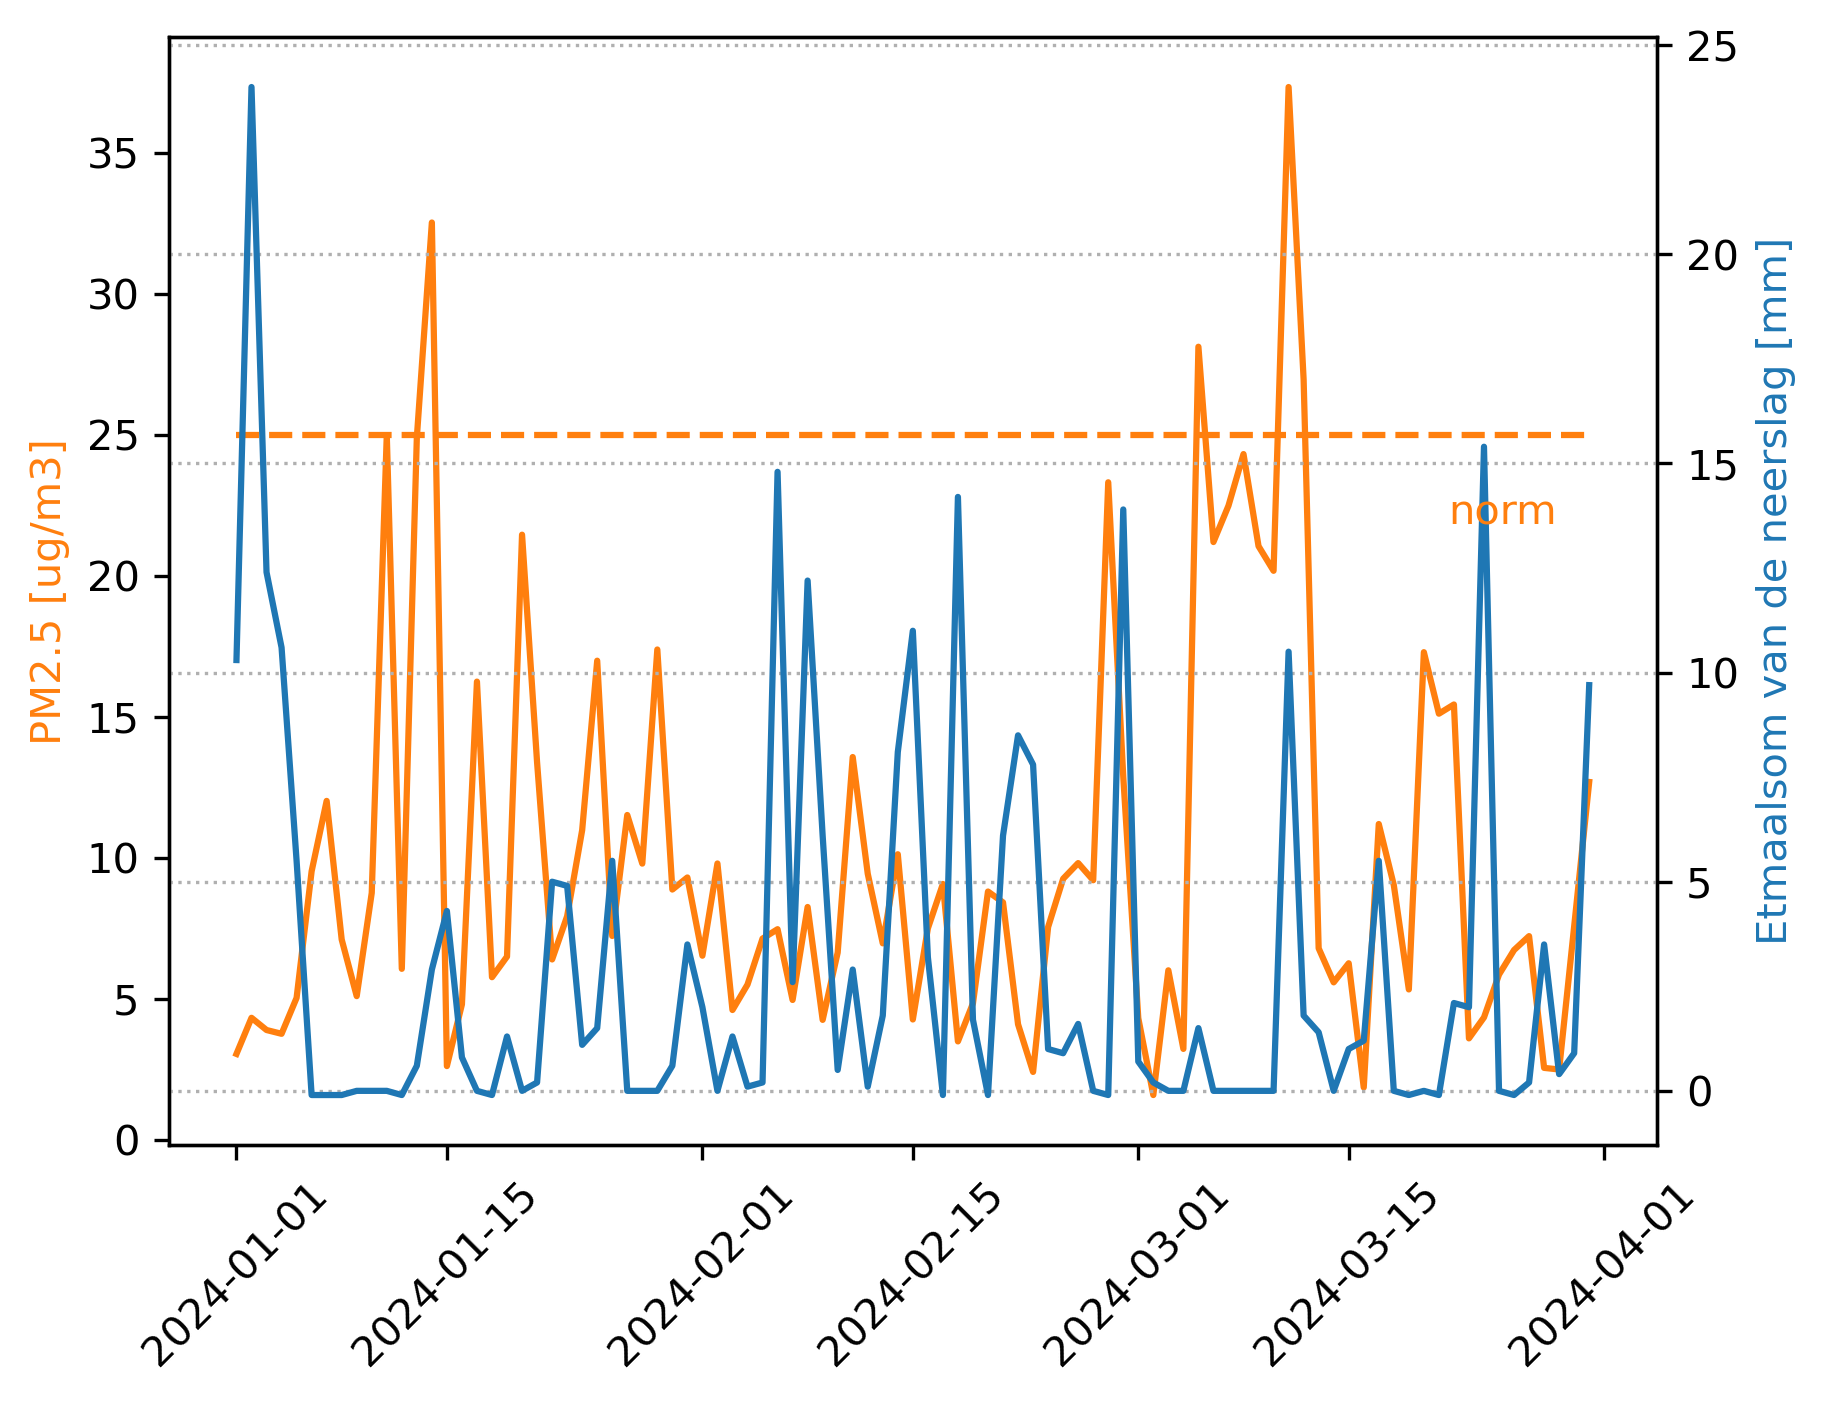

In [49]:
plot_weather_data("RH", "Etmaalsom van de neerslag [mm]")

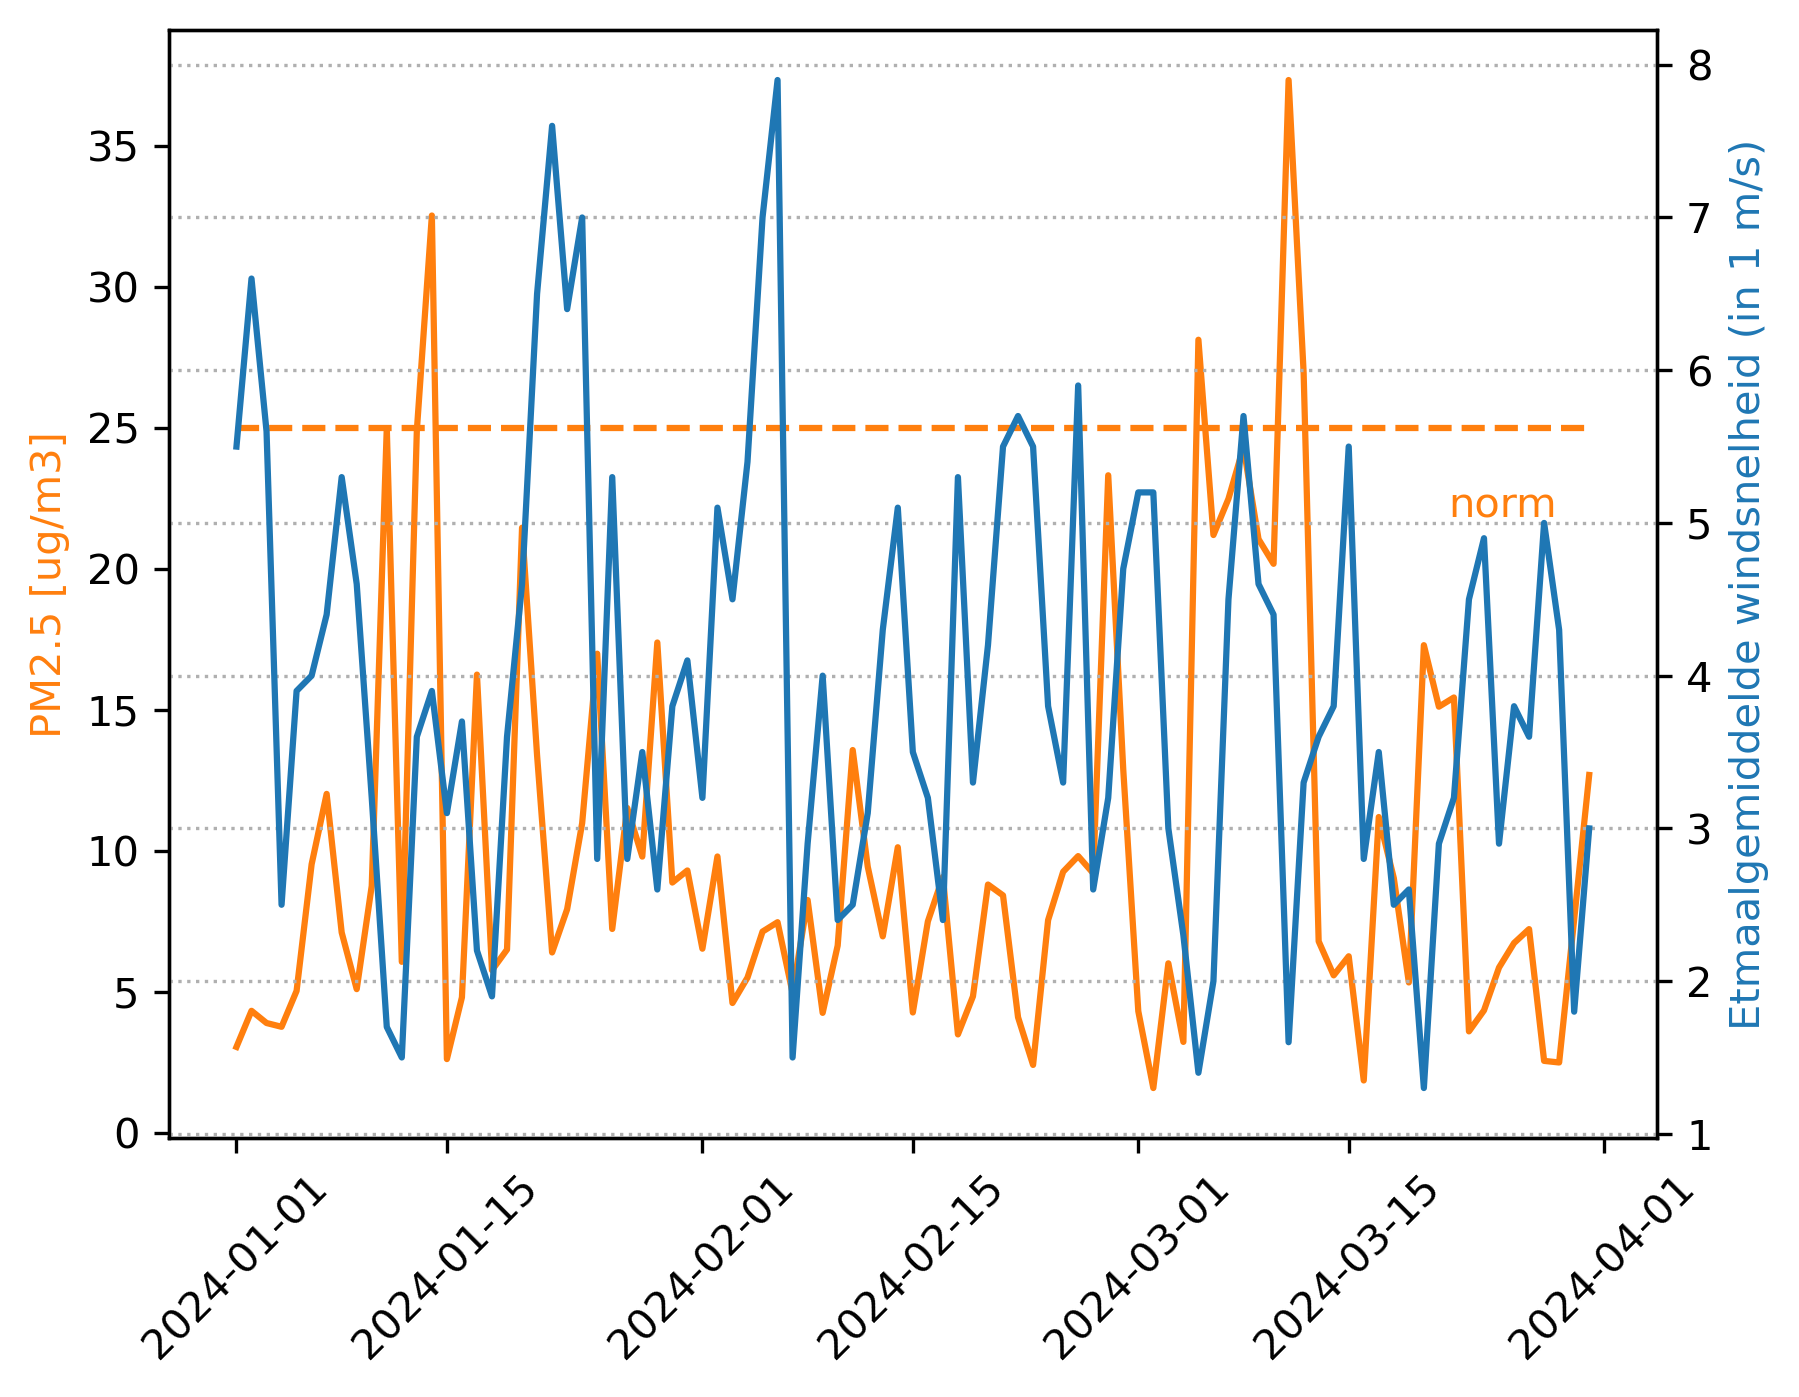

In [50]:
plot_weather_data("FG", "Etmaalgemiddelde windsnelheid (in 1 m/s)")

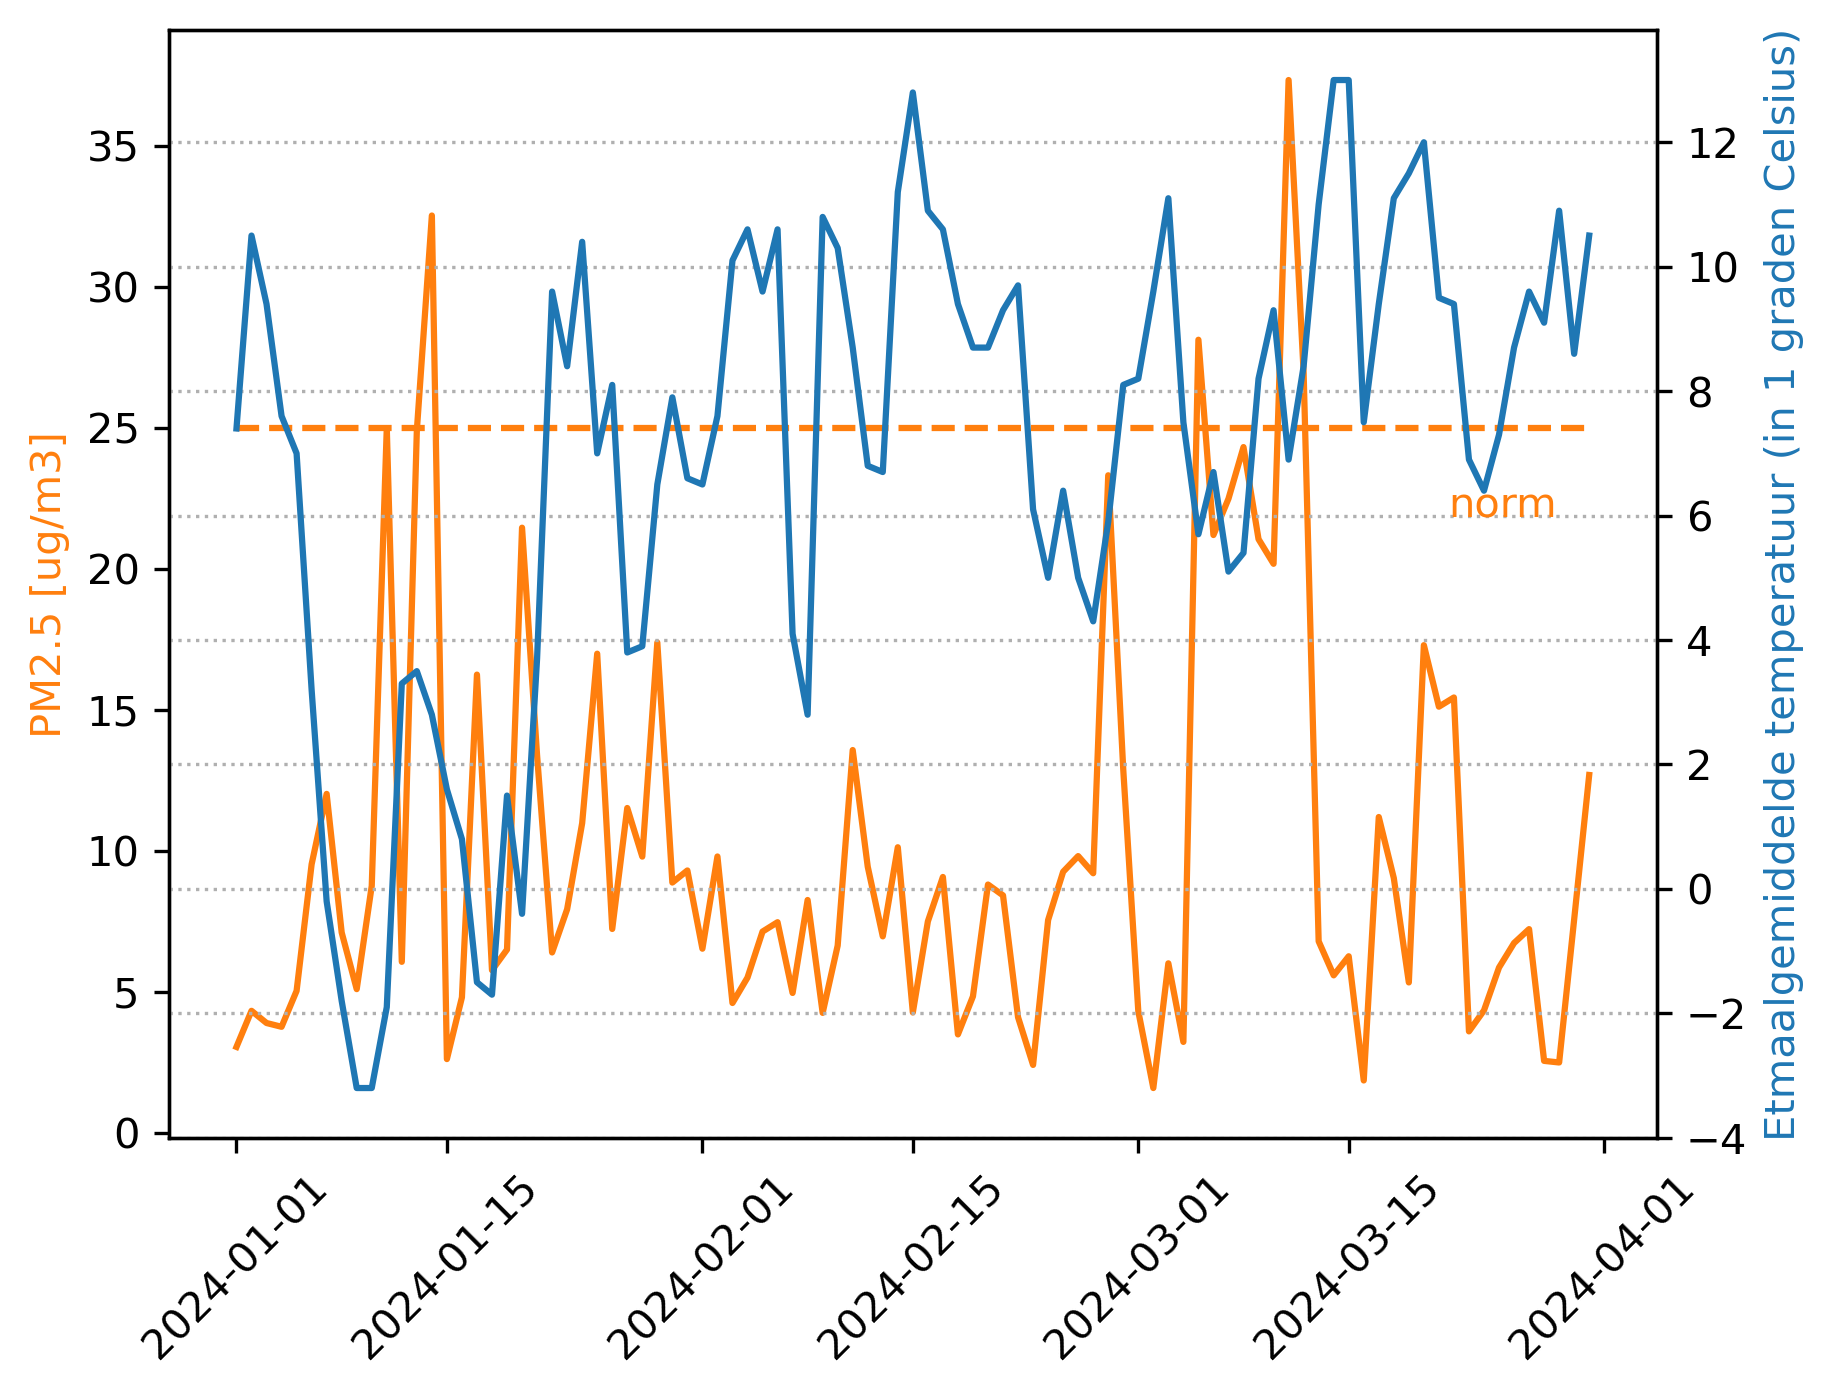

In [51]:
plot_weather_data("TG", "Etmaalgemiddelde temperatuur (in 1 graden Celsius)")


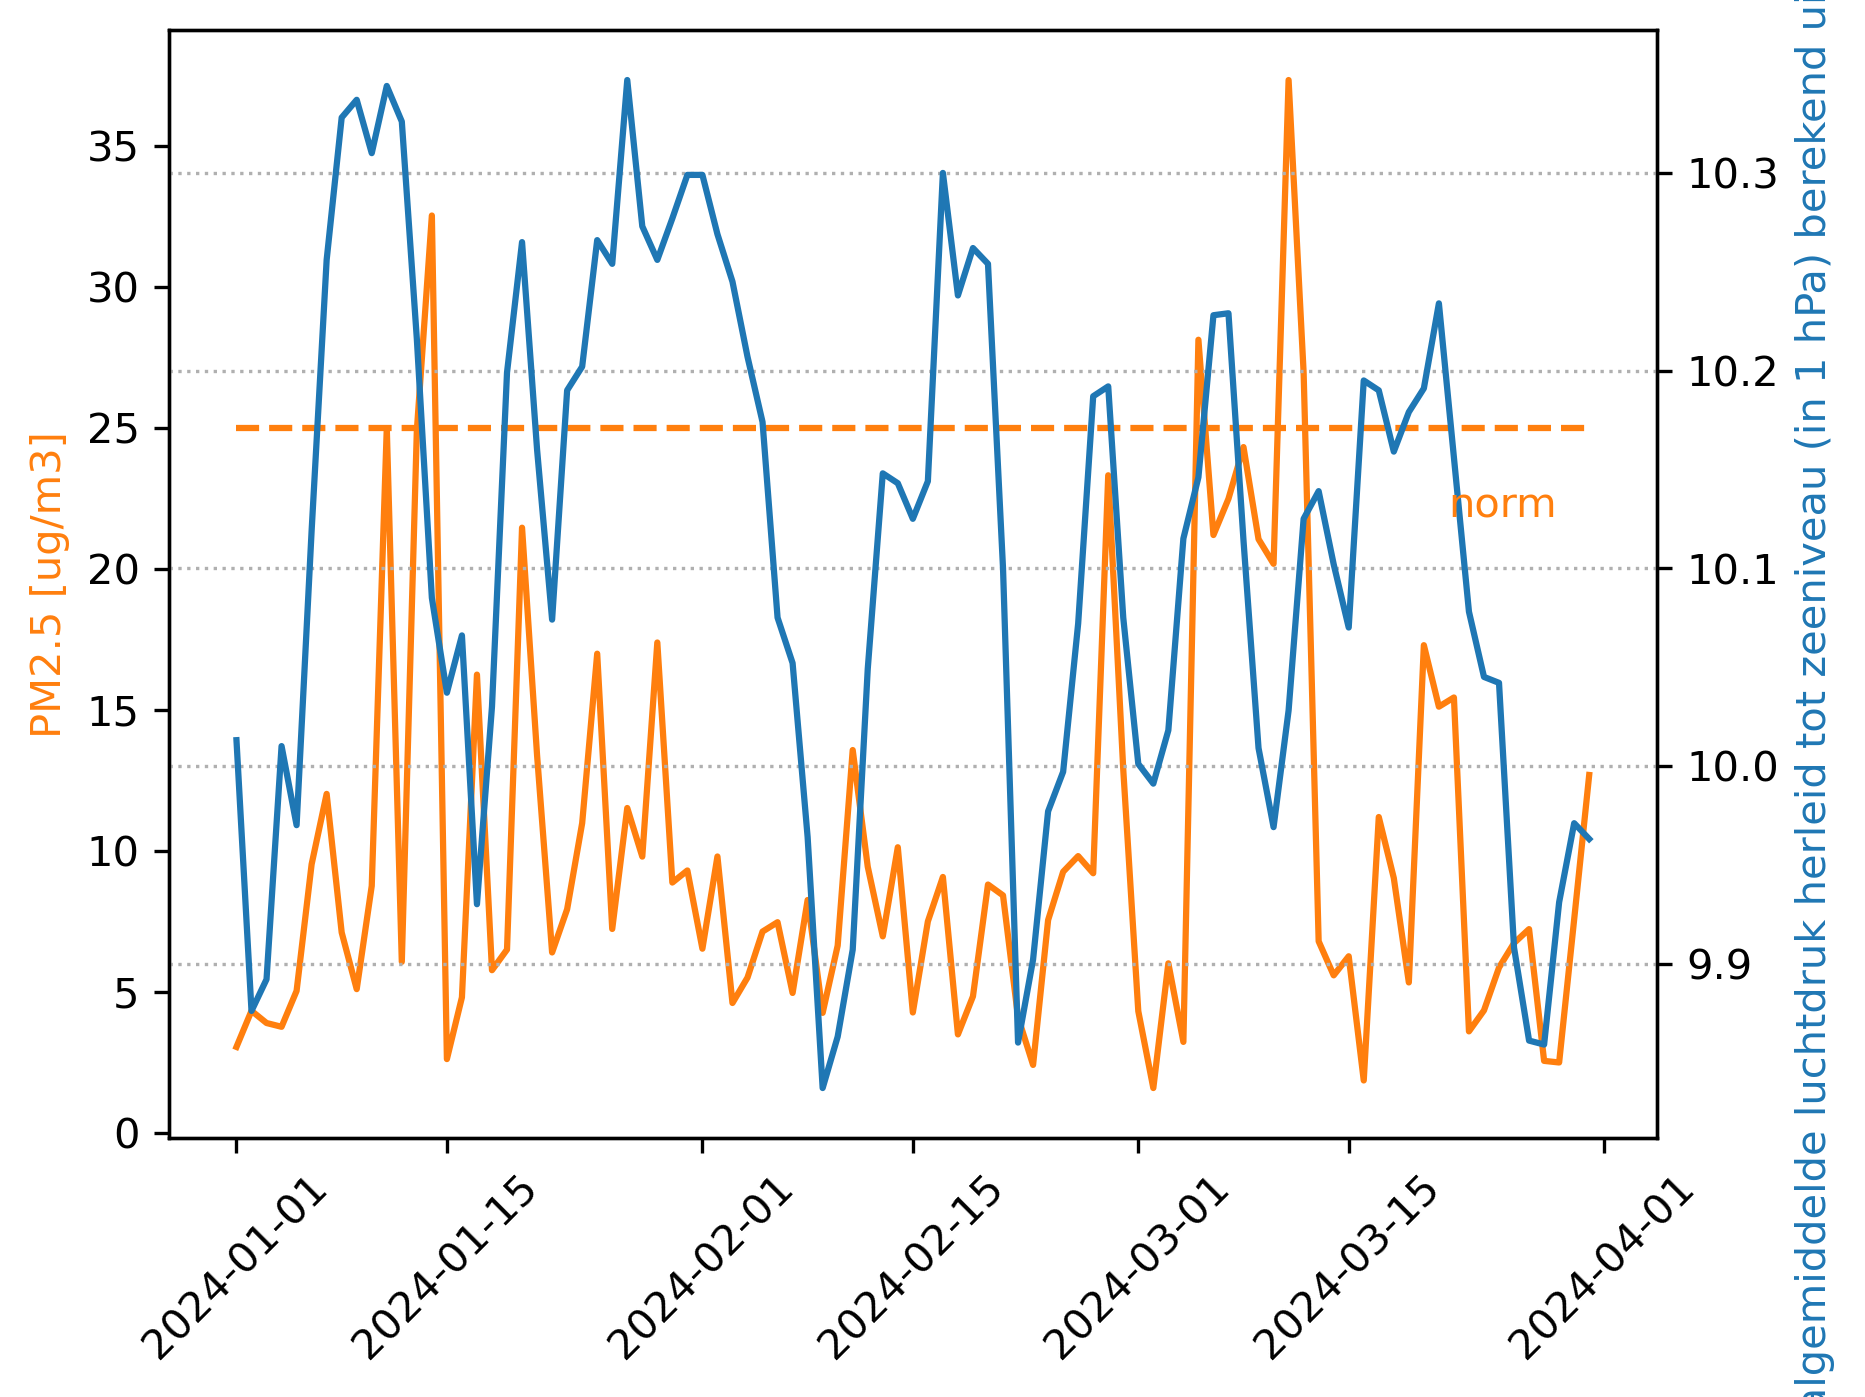

In [65]:
plot_weather_data("PG", "Etmaalgemiddelde luchtdruk herleid tot zeeniveau (in 1 hPa) berekend uit 24 uurwaarden")

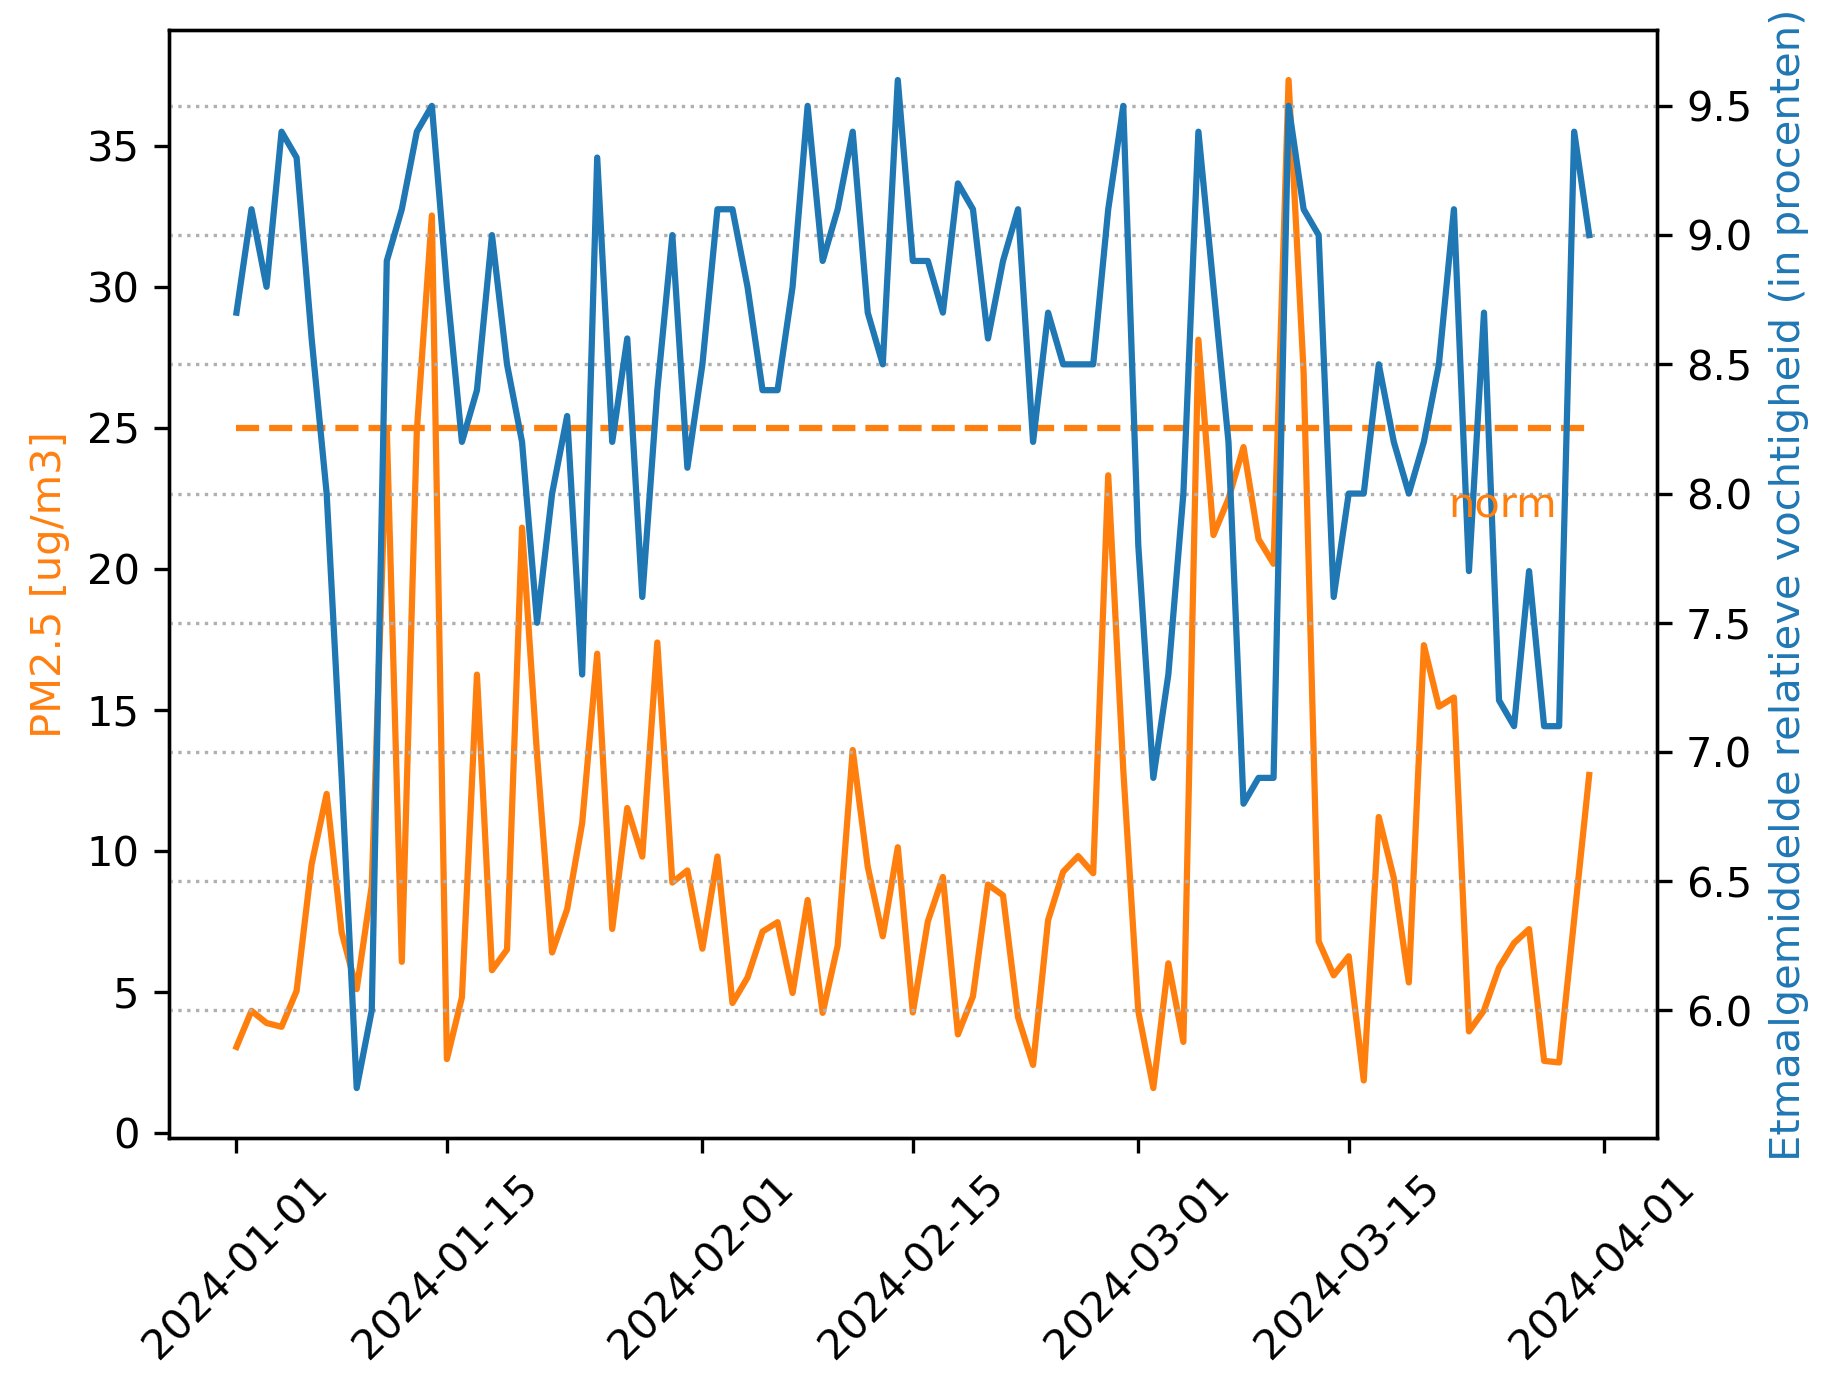

In [84]:
plot_weather_data("UG", "Etmaalgemiddelde relatieve vochtigheid (in procenten)")

In [142]:
corr = dfr.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning:

All-NaN slice encountered

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.12/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning:

All-NaN slice encountered



,STN,RH,FG,TG,PG,UG,pm2_5
STN,nan,nan,nan,nan,nan,nan,nan
RH,nan,1.000000,0.332220,0.241603,-0.356166,0.382674,-0.177586
FG,nan,0.332220,1.000000,0.193474,-0.102570,-0.264548,-0.256081
TG,nan,0.241603,0.193474,1.000000,-0.295639,0.159314,-0.216966
PG,nan,-0.356166,-0.102570,-0.295639,1.000000,-0.051277,0.214320
UG,nan,0.382674,-0.264548,0.159314,-0.051277,1.000000,0.181466
pm2_5,nan,-0.177586,-0.256081,-0.216966,0.214320,0.181466,1.000000


In [131]:
import numpy as np
from statsmodels.api import OLS

X = dfr[['RH','UG', 'TG']]
# X = dfr[['RH', 'FG', 'TG', 'UG', 'PG']]
y = dfr['pm2_5']

In [99]:
dfr.head()

,STN,RH,FG,TG,PG,UG,month,pm2_5
YYYYMMDD,,,,,,,,
2024-01-01 00:00:00+01:00,260,10.3,5.5,7.4,10.013,87,1,3.053841
2024-01-02 00:00:00+01:00,260,24.0,6.6,10.5,9.876,91,1,4.333738
2024-01-03 00:00:00+01:00,260,12.4,5.6,9.4,9.892,88,1,3.901375
2024-01-04 00:00:00+01:00,260,10.6,2.5,7.6,10.010,94,1,3.766929
2024-01-05 00:00:00+01:00,260,5.5,3.9,7.0,9.970,93,1,5.040905


In [137]:
OLS.from_formula("pm2_5 ~ RH + UG + TG ", dfr).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pm2_5   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     4.896
Date:                Wed, 05 Jun 2024   Prob (F-statistic):            0.00342
Time:                        18:11:59   Log-Likelihood:                -303.41
No. Observations:                  91   AIC:                             614.8
Df Residuals:                      87   BIC:                             624.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.1984      7.985     -1.152      0.252     -25.069       6.672
RH            -0.3867      0.172     -2.243      0.027      -0.729      -0.044
UG             2.7674      0.966      2.865      0.005       0.848       4.687
TG            -0.3982      0.197     -2.017      0.047      -0.790      -0.006
==============================================================================
Omnibus:                       30.169   Durbin-Watson:                   1.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.906
Skew:                           1.417   Prob(JB):                     2.40e-11
Kurtosis:                       5.206   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### References

Influence of Temperature and Relative Humidity on PM2.5 Concentration over Delhi https://link.springer.com/article/10.1007/s12647-023-00656-8#:~:text=An%20overall%20strong%20inverse%20relationship,exponentially%20with%20a%20temperature%20decrease.

Humidity plays an important role in the PM2.5 pollution in Beijing https://www.sciencedirect.com/science/article/abs/pii/S0269749114004965?via%3Dihub

Relationships between meteorological parameters and criteria air pollutants in three megacities in China https://www.sciencedirect.com/science/article/abs/pii/S0013935115001218?via%3Dihub

Severe Pollution in China Amplified by Atmospheric Moisture https://www.nature.com/articles/s41598-017-15909-1